# Problem Statement

Human Action Recognition (HAR) aims to identify human behavior. It has a wide range of applications, and therefore has been attracting increasing attention in 


the field of computer vision. Human actions can be represented using various data modalities, such as RGB, skeleton, depth, infrared, point cloud, event stream, 


audio, acceleration, radar, and WiFi signal, which encode different sources of useful yet distinct information and have various advantages depending on the 


application scenarios.


Consequently, lots of existing works have attempted to investigate different types of approaches for HAR using various modalities.


This project was just to build an Image Classification Model using CNN that classifies several human actions, turn this to a production pipeline, try out 



different deployment modes, and to make use of some of the MLOPs tools we used in MLOPs Zoomcamp 2023 cohort course for the completion of the course hosted by 
[DataTalksClub](https://www.linkedin.com/search/results/all/?fetchDeterministicClustersOnly=true&heroEntityKey=urn%3Ali%3Aorganization%3A71802369&keywords=datatalksclub&origin=RICH_QUERY_SUGGESTION&position=0&searchId=0157507a-27bf-439c-b717-8394da03a0fb&sid=6~t) 

### Importing library

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
import pickle
import uuid

c:\Users\Odiaka\miniconda3\envs\bisi10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Setting up the path and loading csv files

In [7]:
train_csv = pd.read_csv("Training_set.csv")
test_csv = pd.read_csv("Testing_set.csv")

In [8]:
train_fol = glob.glob("train/*") 
test_fol = glob.glob("test/*")

In [9]:
train_csv

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [10]:
train_csv.label.value_counts()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

In [11]:
import plotly.express as px
l = train_csv.label.value_counts()
fig = px.pie(train_csv, values=l.values, names=l.index, title='Distribution of Human Activity')
fig.show()

In [12]:
filename = train_csv['filename']

actions = train_csv['label']

In [13]:
filename

0            Image_1.jpg
1            Image_2.jpg
2            Image_3.jpg
3            Image_4.jpg
4            Image_5.jpg
              ...       
12595    Image_12596.jpg
12596    Image_12597.jpg
12597    Image_12598.jpg
12598    Image_12599.jpg
12599    Image_12600.jpg
Name: filename, Length: 12600, dtype: object

In [14]:
actions

0                   sitting
1              using_laptop
2                   hugging
3                  sleeping
4              using_laptop
                ...        
12595               sitting
12596              clapping
12597               sitting
12598               dancing
12599    listening_to_music
Name: label, Length: 12600, dtype: object

### Creating a function to randomly take an image and display it with its label

In [15]:
def disp():
    num = random.randint(1,10000)
    imgg = "Image_{}.jpg".format(num)
    train = "train/"
    if os.path.exists(train+imgg):
        testImage = img.imread(train+imgg)
        plt.imshow(testImage)
        plt.title("{}".format(train_csv.loc[train_csv['filename'] == "{}".format(imgg), 'label'].item()))

    else:
        #print(train+img)
        print("File Path not found \nSkipping the file!!")

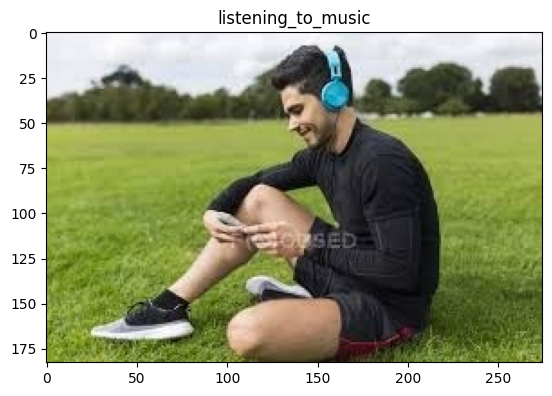

In [16]:
disp()

# Processing data

In [17]:
img_data = []
img_label = []
length = len(train_fol)
for i in (range(len(train_fol)-1)):
    t = 'train/' + filename[i]    
    temp_img = Image.open(t)
    img_data.append(np.asarray(temp_img.resize((160,160))))
    img_label.append(actions[i])

In [18]:
inp_shape = (160,160,3)

In [19]:
iii = img_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [20]:
y_train = to_categorical(np.asarray(train_csv['label'].factorize()[0]))
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
y_train[25]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [22]:
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))

In [23]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
history = vgg_model.fit(iii,y_train, epochs=20)

Epoch 1/20
394/394 [==============================] - 769s 2s/step - loss: 2.1874 - accuracy: 0.4479
Epoch 2/20
394/394 [==============================] - 775s 2s/step - loss: 1.2160 - accuracy: 0.6089
Epoch 3/20
394/394 [==============================] - 769s 2s/step - loss: 0.9412 - accuracy: 0.6897
Epoch 4/20
394/394 [==============================] - 770s 2s/step - loss: 0.7376 - accuracy: 0.7553
Epoch 5/20
394/394 [==============================] - 766s 2s/step - loss: 0.5597 - accuracy: 0.8158
Epoch 6/20
394/394 [==============================] - 764s 2s/step - loss: 0.4122 - accuracy: 0.8702
Epoch 7/20
394/394 [==============================] - 760s 2s/step - loss: 0.3089 - accuracy: 0.8990
Epoch 8/20
394/394 [==============================] - 764s 2s/step - loss: 0.2260 - accuracy: 0.9287
Epoch 9/20
394/394 [==============================] - 766s 2s/step - loss: 0.1638 - accuracy: 0.9502
Epoch 10/20
394/394 [==============================] - 783s 2s/step - loss: 0.1539 - accura

You can uncomment the first line below, and comment the second one out. Weights are lighter than the complete model architecture.

In [53]:
#vgg_model.save_weights("HARmodel.h5")
vgg_model.save("HARmodel_main.h5")

In [54]:
vgg_model

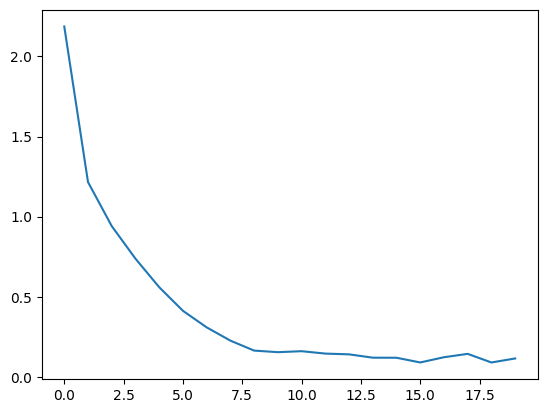

In [42]:
losss = history.history['loss']
plt.plot(losss)

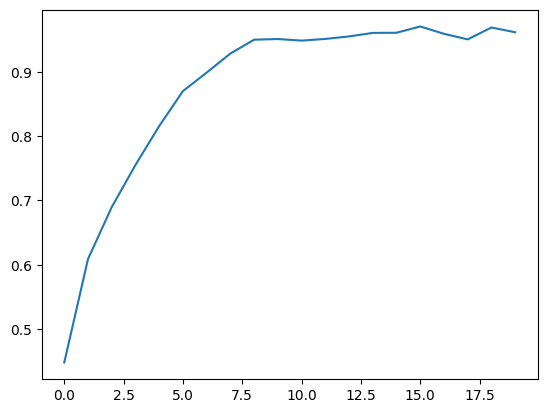

In [43]:
accu = history.history['accuracy']
plt.plot(accu)

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16

# Create a new instance of the VGG16 model
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))




# Load the saved weights into the model
vgg_model.load_weights('HARmodel.h5')


# Custom Testing

In [45]:
# Function to read images as array

def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((160,160)))

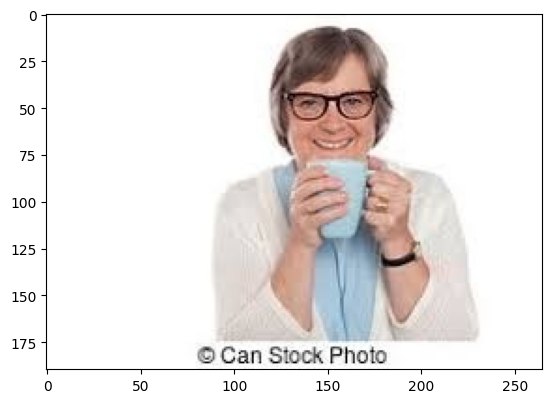

In [46]:
# Function to predict

def test_predict(test_image):
    result = vgg_model.predict(np.asarray([read_image(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
#     print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)
    return prediction
image = img.imread("test\Image_12.jpg")
plt.imshow(image)
#plt.title(prediction)

In [47]:
test_predict('test\Image_22.jpg')

1/1 [==============================] - 0s 188ms/step


6

In [48]:
test_predict('test\Image_5.jpg')

1/1 [==============================] - 0s 130ms/step


0

In [49]:
test_predict('test\Image_21.jpg')

1/1 [==============================] - 0s 83ms/step


4

In [56]:

#model = vgg_model.load_weights("HARmodel_main.h5")
# Save the model as pickle
with open("model.bin", "wb") as f_in:
    pickle.dump(vgg_model, f_in)
